Enfermedad cardíaca

In [13]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [53]:
# Paso 2: Cargar el dataset
df = pd.read_csv("heart_cleveland_upload.csv")
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
5,64,1,0,170,227,0,2,155,0,0.6,1,0,2,0
6,63,1,0,145,233,1,2,150,0,2.3,2,0,1,0
7,61,1,0,134,234,0,0,145,0,2.6,1,2,0,1
8,60,0,0,150,240,0,0,171,0,0.9,0,0,0,0
9,59,1,0,178,270,0,2,145,0,4.2,2,0,2,0


In [15]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


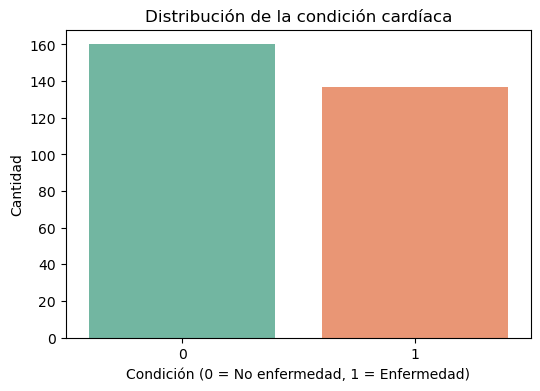

In [19]:
# Ver distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='condition', hue='condition', palette='Set2', legend=False)
plt.title("Distribución de la condición cardíaca")
plt.xlabel("Condición (0 = No enfermedad, 1 = Enfermedad)")
plt.ylabel("Cantidad")
plt.show()

 Se observa que hay más casos sin enfermedad cardíaca que con ella

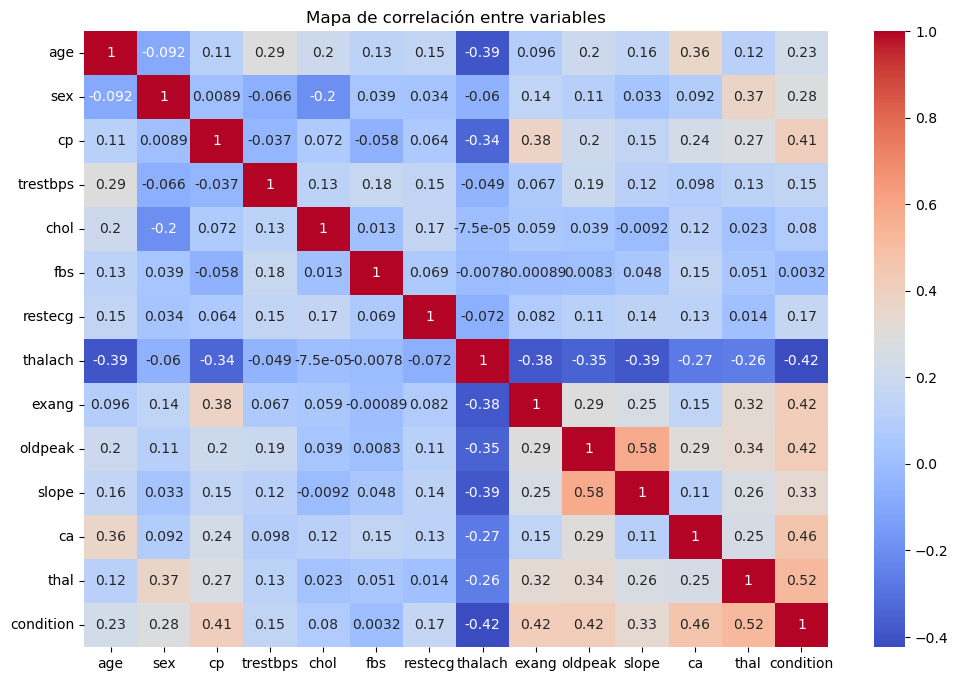

In [24]:
# Correlación entre variables numéricas
# Esto nos ayuda a identificar qué variables tienen mayor relación con la condición cardíaca
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Mapa de correlación entre variables")
plt.show()

Las variables con correlación fuerte (positiva o negativa) con la condición son posibles candidatas para el modelo
Se destaca la importancia de cp, oldpeak, thal, y ca.

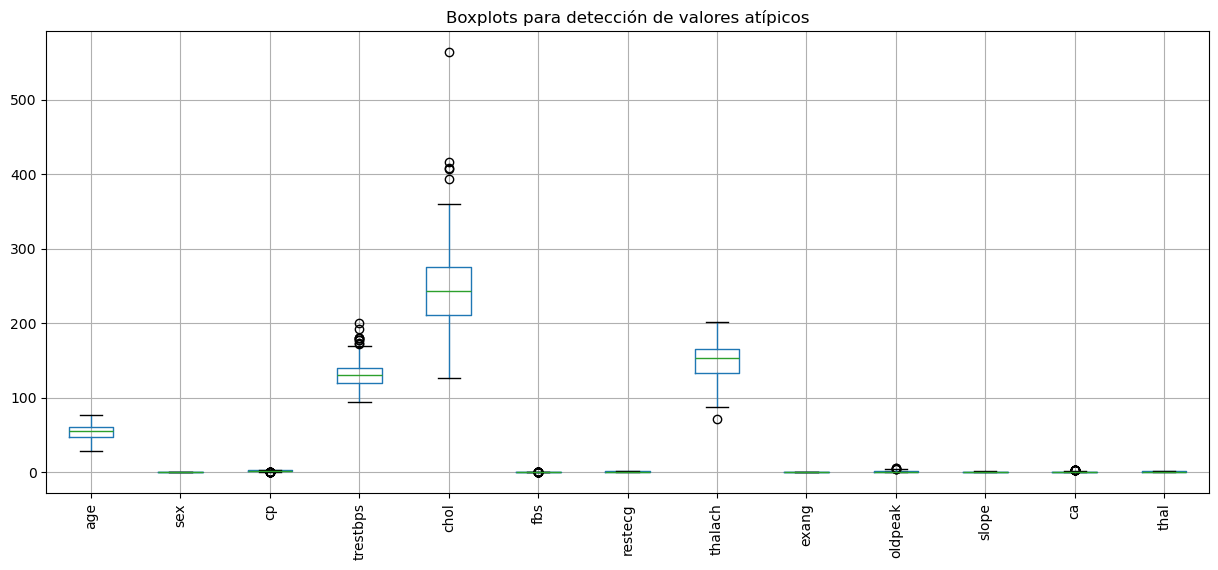

In [27]:
# Boxplot: revisamos la presencia de valores atípicos
plt.figure(figsize=(15,6))
df.drop("condition", axis=1).boxplot(rot=90)
plt.title("Boxplots para detección de valores atípicos")
plt.show()

Algunas variables como 'trestbps', 'chol' y 'thalach' tienen valores extremos visibles

In [43]:
# Paso 4: Preprocesamiento de los datos
# Aquí revisamos si hay valores nulos o inconsistencias en el dataset
print("\nValores faltantes:")
print(df.isnull().sum())
# En este caso, no hay valores faltantes. Si los hubiera, deberíamos imputarlos o eliminarlos


Valores faltantes:
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


In [45]:
# Paso 4: Eliminación de valores atípicos
# Usamos el método IQR para eliminar valores extremos que podrían afectar negativamente el modelo.
# Esto asegura una distribución más normal de los datos.
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cols_numericas = df.drop("condition", axis=1).columns
for col in cols_numericas:
    df = remove_outliers_iqr(df, col)

print("Datos después de eliminar valores atípicos:")
print(df.shape)


Datos después de eliminar valores atípicos:
(212, 14)


In [55]:
df['condition'].value_counts()

condition
0    160
1    137
Name: count, dtype: int64

In [61]:
# Paso 6: División en conjuntos de entrenamiento y prueba
# Separamos los datos en entrenamiento y prueba para evaluar el rendimiento del modelo de forma objetiva
X = df.drop("condition", axis=1)
y = df["condition"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Paso 7: Entrenamiento del modelo de regresión logística
modelo = LogisticRegression(max_iter=1000, solver='liblinear')
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

Text(0.5, 1.0, 'Matriz de Confusión')

<Figure size 800x600 with 0 Axes>

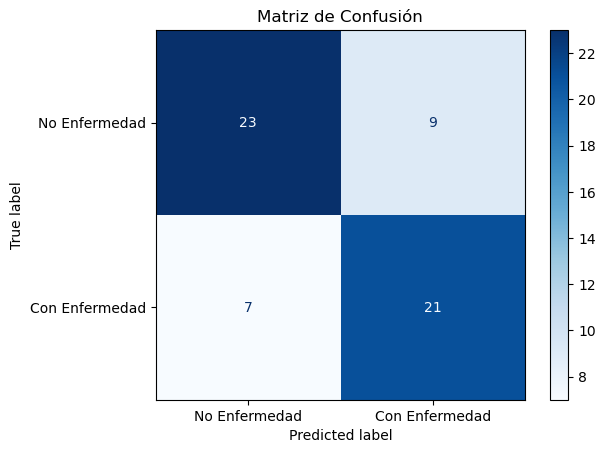

In [87]:
# Paso 9: Evaluación del modelo
# Calculamos la matriz de confusión para ver cuántas predicciones fueron correctas o incorrectas.
y_pred = modelo.predict(X_test)
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Enfermedad", "Con Enfermedad"])
cmd.plot(cmap='Blues', values_format='d')
plt.title("Matriz de Confusión")

In [81]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.70      0.75      0.72        28

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



Este análisis nos permitió identificar las variables más relevantes que influyen en la presencia de enfermedad cardíaca.
La regresión logística, aunque más simple, ofrece un modelo fácil de interpretar y generalmente efectivo para clasificación binaria.
Para mejorar la precisión, podrían explorarse modelos como Random Forest, SVM o redes neuronales dependiendo del caso de uso.